In [1]:
using PyPlot;
using Random;
using LinearAlgebra;
using Statistics;
using CSV;

In [2]:
include("src/utils.jl");

# Problem 19.1 #

Consider the problem of finding the point on a curve closest to (1,1,1). Specifically, the optimization problem 

\begin{align*}
\text{minimize }&\quad (x_1-1)^2 +(x_2-1)^2 +(x_3-1)^2\\
\text{subject to }&\quad x_1^2+0.5x_2^2+x_3^2-1 = 0\\
&\quad 0.8x_1^2+2.5x_2^2+x_3^2+2x_1x_3-x_1-x_2-x_3-1 = 0
\end{align*}

Equivalently the problem can be written as 

$$
\begin{align*}
    \text{minimize }&\quad f(x)\\
    \text{subject to }&\quad g(x) = 0
\end{align*}
$$
where $f : \mathbf{R} \rightarrow \mathbf{R}$ and $g : \mathbf{R}^3 \rightarrow \mathbf{R}^2$. The Jacobians are given by 

$$
\begin{align*}
    Df = \begin{bmatrix}
        2(x_1-1) & 2(x_2-1) & 2(x_3-1)
    \end{bmatrix}\quad
    Dg = \begin{bmatrix}
        2x_1 & x_2 & 2x_3\\
        1.6x_1+2x_3-1 & 5x_2-1 & 3x_3+2x_1-1
    \end{bmatrix}
\end{align*}
$$

In [3]:
function f(x::Vector{T}) where T <: Real
    return sum((x - vec(ones(3))) .^2)
end

function f_jacobian(x::Vector{T}) where T <: Real
    return 2 * (x .- 1)';
end

function g(x::Vector{T}) where T <: Real
    squared_input = x.^2;
    g1 = sum(squared_input .* (vec([1 0.5 1]))) - 1;
    g2 = sum(squared_input .* vec([0.8 2.5 1])) + 2 * x[1] * x[3] - sum(x) - 1;
    
    return vcat(g1,g2);
end

function g_jacobian(x::Vector{T}) where T <: Real
    g1_deriv = vec([2 1 2]) .* x;
    g2_deriv = vec([1.6 5 3]) .* x + vec([2*x[3] 0 2*x[1]]) .- 1;
    
    return 1 * hcat(g1_deriv, g2_deriv)'
end

g_jacobian (generic function with 1 method)

In [4]:
Random.seed!(791074);
xtraj_p, mu_p, cume_iters_p = penalty_algo((3,1,2), f, f_jacobian, g, g_jacobian; xinit=vec(zeros(3)), max_iters=100);
xtraj_al, mu_al, cume_iters_al = augmented_lagrangian((3,1,2), f, f_jacobian, g, g_jacobian; xinit=vec(zeros(3)), max_iters=100);

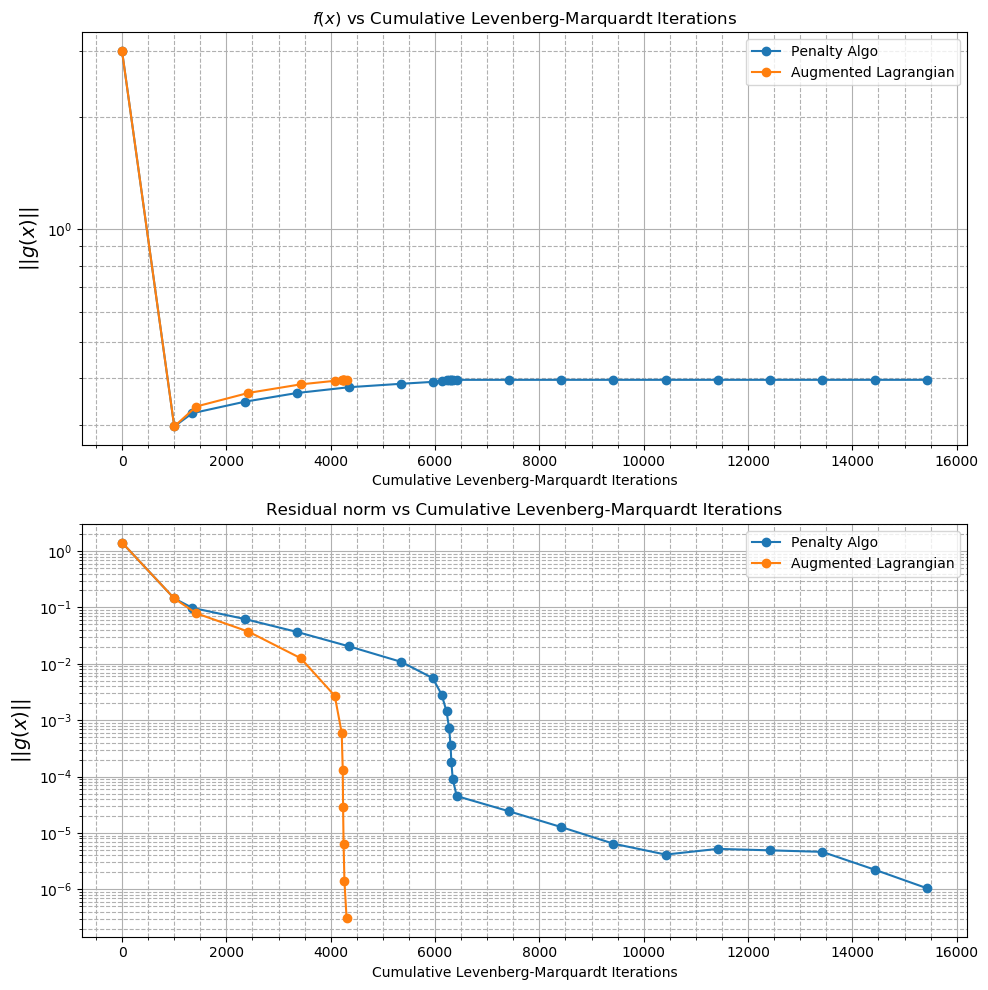

In [5]:
figure(figsize=(10,10));

subplot(211);
objective_p = [norm(f(xtraj_p[:,i])) for i=1:size(xtraj_p,2)];
objective_al = [norm(f(xtraj_al[:,i])) for i=1:size(xtraj_al,2)];

semilogy(cume_iters_p, objective_p, marker="o", label="Penalty Algo");
semilogy(cume_iters_al, objective_al, marker="o", label="Augmented Lagrangian");

legend();
title(L"$f(x)$ vs Cumulative Levenberg-Marquardt Iterations");
ylabel(L"$||g(x)||$", fontsize=14);
xlabel("Cumulative Levenberg-Marquardt Iterations");

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

subplot(212);
equality_residual_p = [norm(g(xtraj_p[:,i])) for i=1:size(xtraj_p,2)];
equality_residual_al = [norm(g(xtraj_al[:,i])) for i=1:size(xtraj_al,2)];

semilogy(cume_iters_p, equality_residual_p, marker="o", label="Penalty Algo");
semilogy(cume_iters_al, equality_residual_al, marker="o", label="Augmented Lagrangian");

legend();
title("Residual norm vs Cumulative Levenberg-Marquardt Iterations");
ylabel(L"$||g(x)||$", fontsize=14);
xlabel("Cumulative Levenberg-Marquardt Iterations");

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on()

PyPlot.tight_layout();

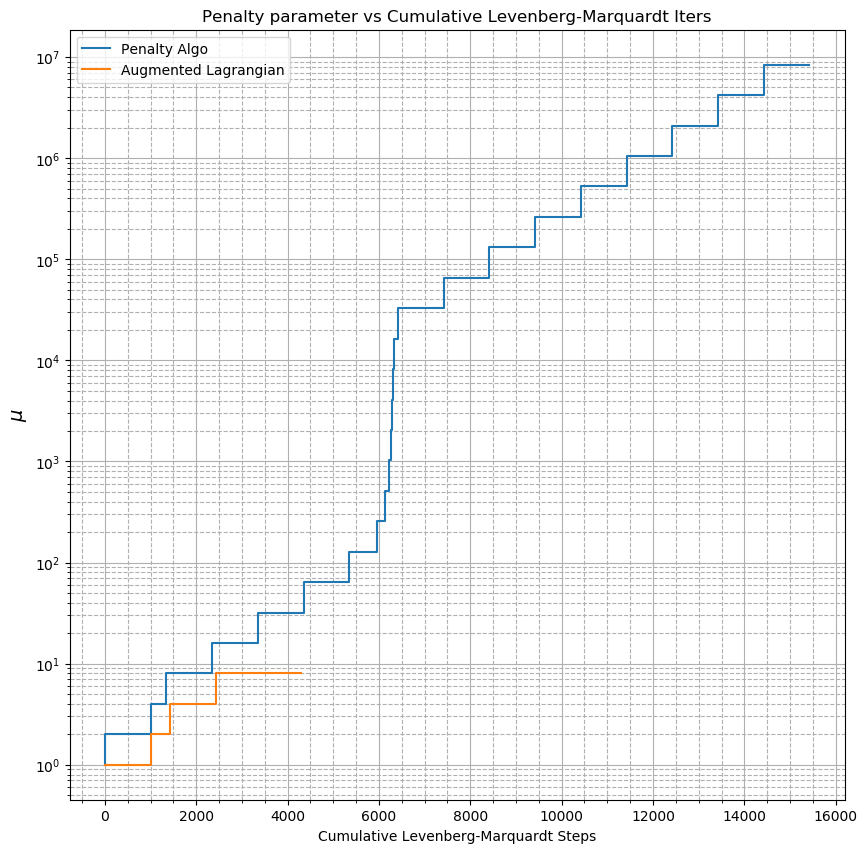

In [6]:
figure(figsize=(10,10));

semilogy(1.0, 1.0,"w");
step(cume_iters_p[:], mu_p[:], label="Penalty Algo");
step(cume_iters_al[:], mu_al[:], label="Augmented Lagrangian");

legend();
title("Penalty parameter vs Cumulative Levenberg-Marquardt Iters");
xlabel("Cumulative Levenberg-Marquardt Steps");
ylabel(L"$\mu$", fontsize=14);

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

# Problem 19.2 #

The downside-risk portfolio optimization problem is given by 

\begin{align*}
    \text{minimize}_{\omega}\quad& \frac{1}{T} \Sigma_{t=1}^T \left(\max\left\{\rho^{\text{tar}} - r_t^T\omega, 0\right\}\right)^2\\
    \text{subject to}\quad& \begin{bmatrix}
    \mathbf{1}^T\\
    \mu^T
    \end{bmatrix}\omega = \begin{bmatrix}
    1 \\
    \rho^{\text{tar}} 
    \end{bmatrix}
\end{align*}

where $r_t^T$ is the $t$'th row of $R\in \mathbf{R}^{T\times n}$ and $n$ is the number of assets

This is a constrained non-linear least squares problem with $f_i(\omega) = \max\left\{\rho^{\text{tar}} - r_i^T\omega, 0\right\}$ and $g(\omega) = [\mathbf{1},\ \mu]^T \omega - [1,\ \rho^{\text{tar}}]^T$. The Jacobians are 

\begin{align*}
    Df(\omega) = \begin{bmatrix}
          -r_1^T\mathbf{1}(\rho^{\text{tar}} - r_1^T\omega > 0)\\
          -r_2^T\mathbf{1}(\rho^{\text{tar}} - r_2^T\omega > 0)\\
          \vdots \\
          -r_T^T\mathbf{1}(\rho^{\text{tar}} - r_T^T\omega > 0)\\
    \end{bmatrix}\quad
    Dg(\omega) = \begin{bmatrix}
                \mathbf{1}^T\\
                \mu^T         
    \end{bmatrix}
\end{align*}

In [7]:
function downside_risk(omega::Vector{T}, R::Array{T,2}, rho::T) where T <: Real
    return max.(rho .- R * omega, 0)
end

function downside_risk_jacobian(omega::Vector{T}, R::Array{T,2}, rho::T) where T <: Real
    return -R .* ((rho .- R * omega) .> 0)
end

function portfolio_constraint(omega::Vector{T}, mu::Vector{T}, rho::T) where T <: Real
    g1 = sum(omega) - 1;
    g2 = dot(mu, omega) - rho;
    
    return vcat(g1, g2);
end

function portfolio_constraint_jacobian(omega::Vector{T}, mu::Vector{T}) where T <: Real
    n = length(omega);
    dg1 = vec(ones(n));
    dg2 = vec(mu);
    
    return 1 * hcat(dg1, dg2)';
end

function stddev_risk(omega::Vector{T}, R::Array{T,2}, rho::T) where T <: Real
    return R * omega .- rho;
end

function stddev_risk_jacobian(R::Array{T,2}) where T <: Real
    return R
end

stddev_risk_jacobian (generic function with 1 method)

In [8]:
function daily_returns(X)
    return (X[:Close] - X[:Open]) ./ X[:Open]
end

function portfolio_value(r::Vector{T}, V=10000) where T<:Real
    N = length(r);
    
    return V * vec([prod(1 .+ r[1:i]) for i in 1:N]);
end

portfolio_value (generic function with 2 methods)

In [9]:
fb_df = CSV.read("data/fb.csv");
aapl_df = CSV.read("data/aapl.csv");
amzn_df = CSV.read("data/amzn.csv");
nflx_df = CSV.read("data/nflx.csv");
goog_df = CSV.read("data/goog.csv");

In [10]:
fb_returns = daily_returns(fb_df);
aapl_returns = daily_returns(aapl_df);
amzn_returns = daily_returns(amzn_df);
nflx_returns = daily_returns(nflx_df);
goog_returns = daily_returns(goog_df);

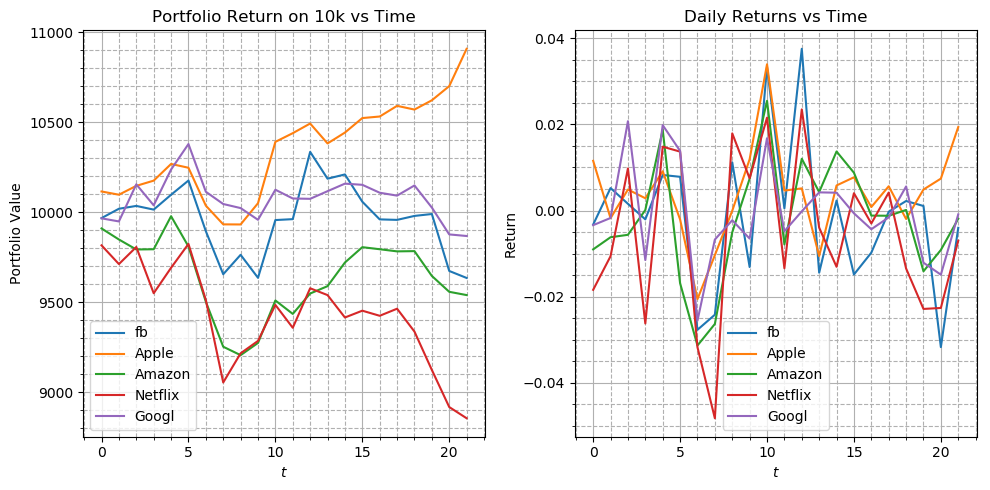

In [11]:
figure(figsize=(10,5));

subplot(121);
plot(portfolio_value(fb_returns), label="fb");
plot(portfolio_value(aapl_returns), label="Apple");
plot(portfolio_value(amzn_returns), label="Amazon");
plot(portfolio_value(nflx_returns), label="Netflix");
plot(portfolio_value(goog_returns), label="Googl");

legend();
title("Portfolio Return on 10k vs Time");
xlabel(L"$t$");
ylabel("Portfolio Value");

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

subplot(122);

plot(fb_returns, label="fb");
plot(aapl_returns, label="Apple");
plot(amzn_returns, label="Amazon");
plot(nflx_returns, label="Netflix");
plot(goog_returns, label="Googl");

legend();
title("Daily Returns vs Time");
xlabel(L"$t$");
ylabel("Return");

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

PyPlot.tight_layout();

In [12]:
R_faang = hcat(fb_returns, aapl_returns, amzn_returns, nflx_returns, goog_returns);
mu_faang = vec(mean(R_faang, dims=1));
T, n = size(R_faang);
p = 2;

In [13]:
expected_returns = range(0, stop=0.1, length=25);
opt_portfolio_downside = zeros(n, 25);
opt_portfolio_stddev = zeros(n, 25);

i = 0;
for rho_tar in expected_returns
    global i += 1

    xtraj_downside_al, mu_downside_al, cume_iters_downside_al = augmented_lagrangian((n,T,p)
                                                                                      , x -> downside_risk(x, R_faang, rho_tar)
                                                                                      , x -> downside_risk_jacobian(x, R_faang, rho_tar)
                                                                                      , x -> portfolio_constraint(x, mu_faang, rho_tar)
                                                                                      , x -> portfolio_constraint_jacobian(x, mu_faang)
                                                                                      ; max_iters=100);
    
     xtraj_stddev_al, mu_stddev_al, cume_iters_stddev_al = augmented_lagrangian((n,T,p)
                                                                                  , x -> stddev_risk(x, R_faang, rho_tar)
                                                                                  , x -> stddev_risk_jacobian(R_faang)
                                                                                  , x -> portfolio_constraint(x, mu_faang, rho_tar)
                                                                                  , x -> portfolio_constraint_jacobian(x, mu_faang)
                                                                                  ; max_iters=100);
    global opt_portfolio_downside[:,i] = xtraj_downside_al[:,end];
    global opt_portfolio_stddev[:, i] = xtraj_stddev_al[:,end];

end

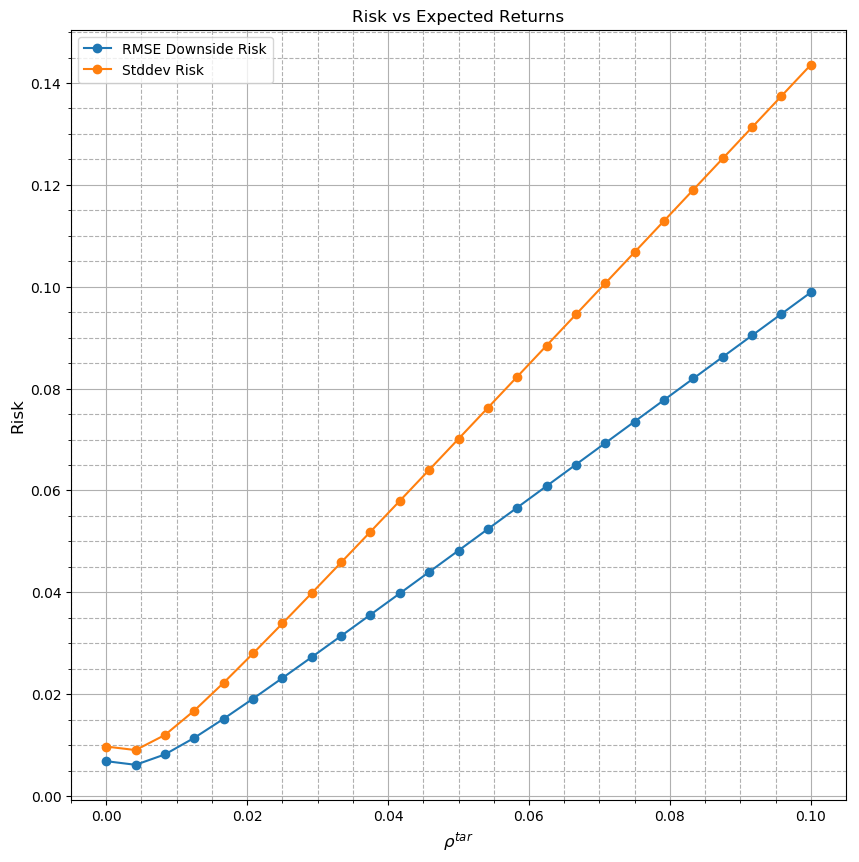

In [14]:
opt_downside_risk = [rmse(downside_risk(vec(opt_portfolio_downside[:,i]), R_faang, expected_returns[i])) for i in 1:size(opt_portfolio_downside, 2)];
opt_stddev_risk = [rmse(stddev_risk(opt_portfolio_stddev[:,i], R_faang, expected_returns[i])) for i in 1:size(opt_portfolio_stddev, 2)];

figure(figsize=(10,10));

plot(vec(expected_returns), vec(opt_downside_risk), marker="o", label="RMSE Downside Risk");
plot(vec(expected_returns), vec(opt_stddev_risk), marker="o", label="Stddev Risk");

legend();
title("Risk vs Expected Returns");
xlabel(L"$\rho^{tar}$", fontsize=12);
ylabel("Risk", fontsize=12);

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

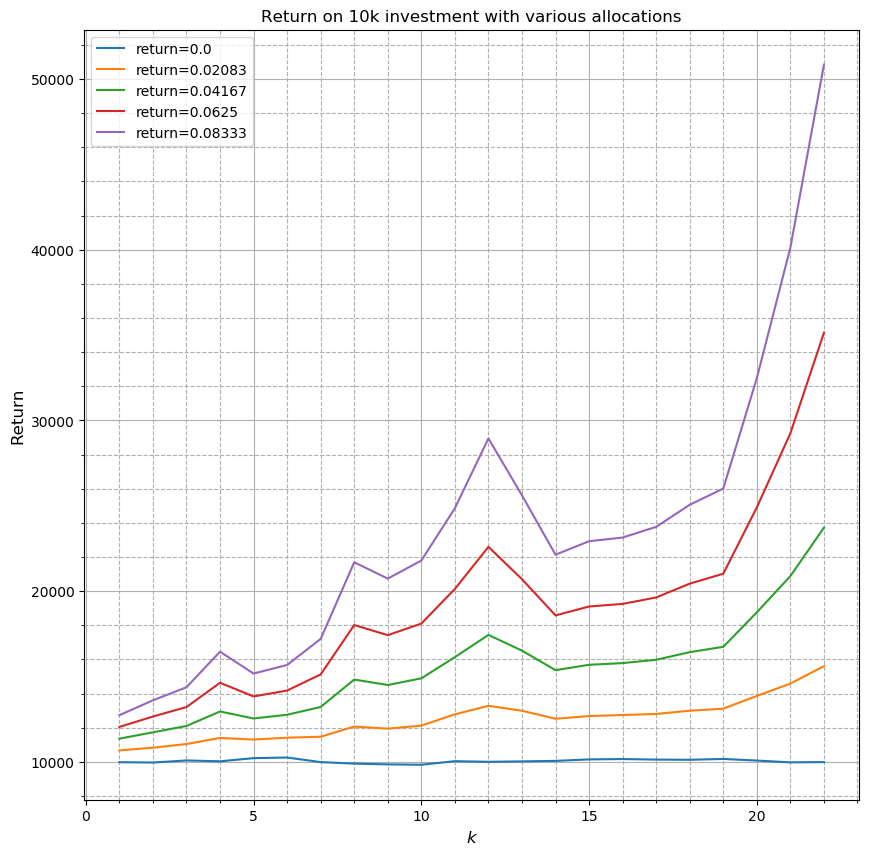

In [15]:
opt_downside_portfolio_val = [portfolio_value(R_faang * opt_portfolio_downside[:,i]) for i in 1:5:size(opt_portfolio_downside, 2)];

figure(figsize=(10,10));

for i in 1:5:size(opt_portfolio_downside, 2);
    rho = round(expected_returns[i], sigdigits=4);
    plot(1:T, portfolio_value(R_faang * opt_portfolio_downside[:,i]), label="return=$rho")
end


legend();
title("Return on 10k investment with various allocations");
xlabel(L"$k$", fontsize=12);
ylabel("Return", fontsize=12);

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

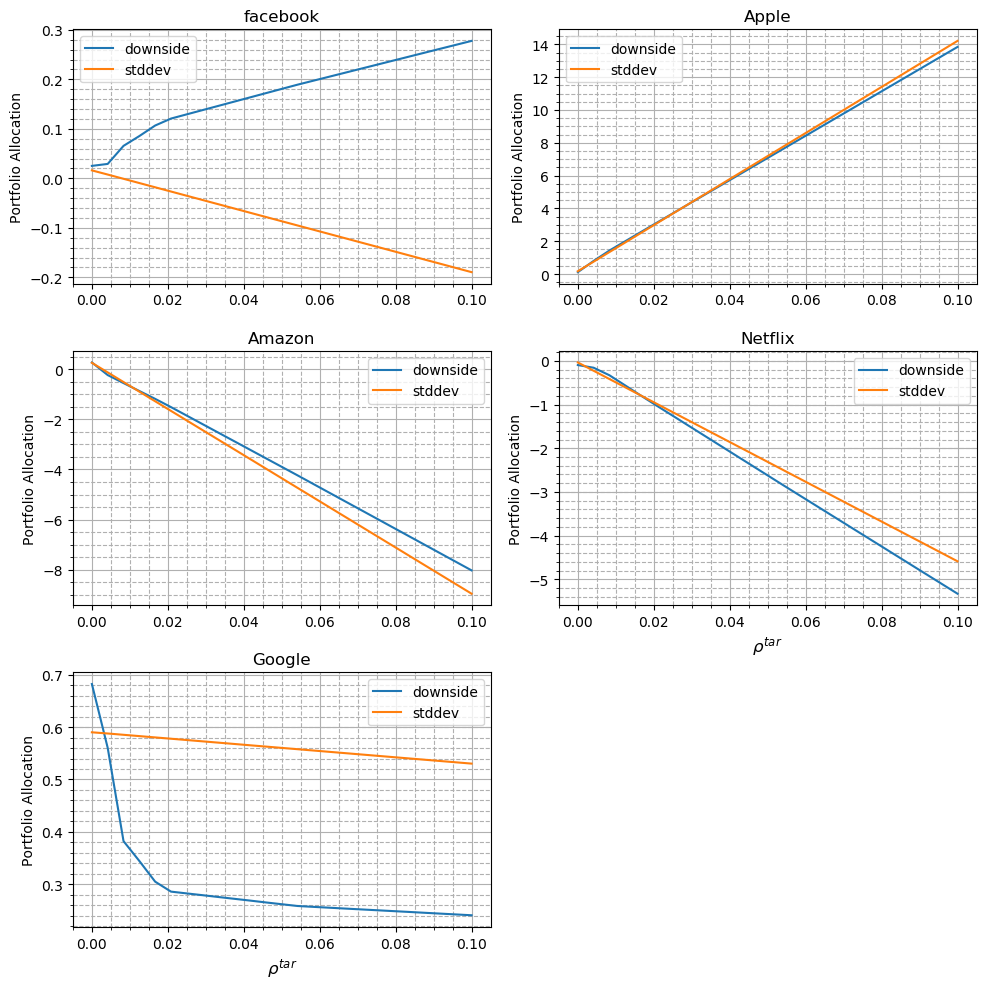

In [16]:
figure(figsize=(10,10));

subplot(321);
plot(expected_returns, vec(opt_portfolio_downside[1,:]), label="downside");
plot(expected_returns, vec(opt_portfolio_stddev[1,:]), label="stddev");

legend();
title("facebook");
ylabel("Portfolio Allocation");

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

subplot(322);
plot(expected_returns, vec(opt_portfolio_downside[2,:]), label="downside");
plot(expected_returns, vec(opt_portfolio_stddev[2,:]), label="stddev");

legend();
title("Apple");
ylabel("Portfolio Allocation");

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

subplot(323);
plot(expected_returns, vec(opt_portfolio_downside[3,:]), label="downside");
plot(expected_returns, vec(opt_portfolio_stddev[3,:]), label="stddev");

legend();
title("Amazon");
ylabel("Portfolio Allocation");

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

subplot(324);
plot(expected_returns, vec(opt_portfolio_downside[4,:]), label="downside");
plot(expected_returns, vec(opt_portfolio_stddev[4,:]), label="stddev");

legend();
title("Netflix");
xlabel(L"$\rho^{tar}$", fontsize=12);
ylabel("Portfolio Allocation");

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

subplot(325);
plot(expected_returns, vec(opt_portfolio_downside[5,:]), label="downside");
plot(expected_returns, vec(opt_portfolio_stddev[5,:]), label="stddev");

legend();
title("Google");
xlabel(L"$\rho^{tar}$", fontsize=12);
ylabel("Portfolio Allocation");


grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

PyPlot.tight_layout()

# Problem 19.3 #

The boolean least squares problem can be written as 
\begin{align*}
    \text{minimize}&\quad ||Ax - b||^2 \\
    \text{subject to}&\quad x_i^2 = 1 \quad i=1,\ldots,n
\end{align*}

This is a least squares problem with nonlinear constraints where $f(x) = Ax - b$ and $g(x) = [x_1^2-1,\ldots,x_n^2-1]^T$. The Jacobians are easily seen to be $Df = A$ and $Dg = 2\cdot \mathbf{diag}(x_1,\ldots,x_n)$.

In [17]:
Random.seed!(470480);

m = 500;
n = 500;

A = randn(m,n);
b = vec(randn(m));

In [18]:
x_ls = A \ b;
x_bool_ls = sign.(x_ls);
f_ls = sum((A*x_ls - b) .^2);
f_bool_ls = sum((A*x_bool_ls - b) .^2);

In [19]:
xtraj_al, mu_al, cume_iters_al = augmented_lagrangian((n,m,n)
                                                      , x -> A*x - b
                                                      , x -> A
                                                      , x -> x.^2 .- 1
                                                      , x -> 2 * Diagonal(x)
                                                      ; xinit=x_ls
                                                      , max_iters=100);

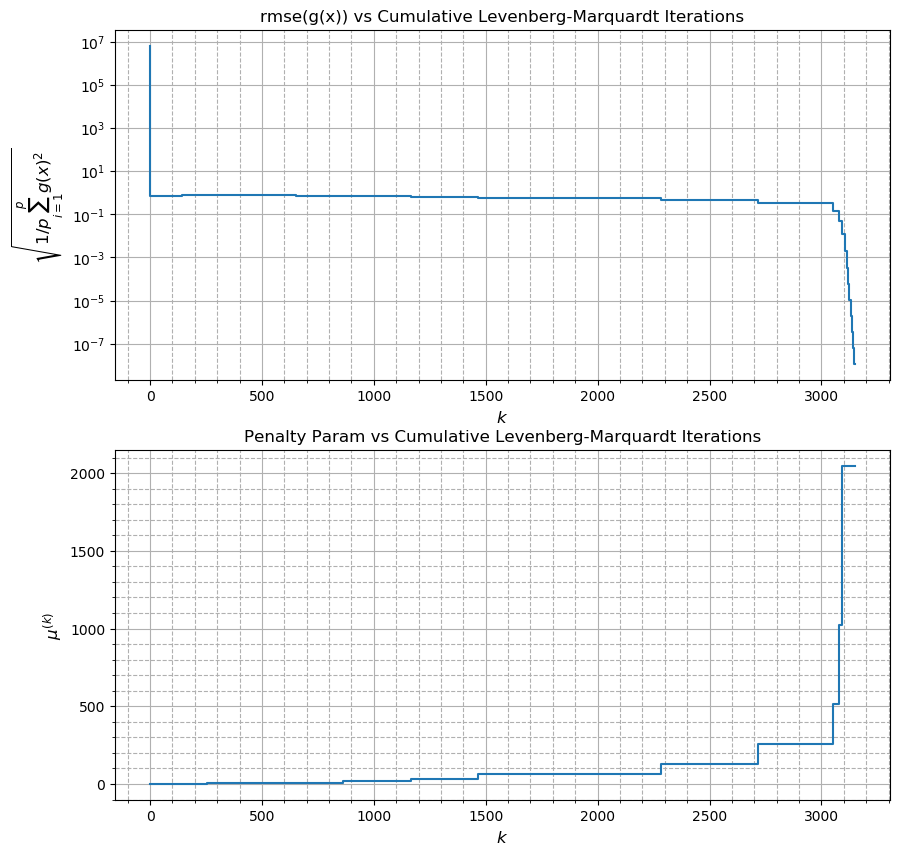

In [20]:
figure(figsize=(10,10));

subplot(211);
constraint_error = [rmse(xtraj_al[:,i].^2 .- 1) for i in 1:size(xtraj_al, 2)];
semilogy(1.0, 1.0, "w")
step(cume_iters_al, constraint_error);

title("rmse(g(x)) vs Cumulative Levenberg-Marquardt Iterations");
xlabel(L"$k$", fontsize=12);
ylabel(L"$\sqrt{1/p\sum_{i=1}^p g(x)^2}$", fontsize=12);

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

subplot(212);
step(cume_iters_al, mu_al);

title("Penalty Param vs Cumulative Levenberg-Marquardt Iterations");
xlabel(L"$k$", fontsize=12);
ylabel(L"$\mu^{(k)}$", fontsize=12);

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();

In [21]:
ftraj_exact_al = [sum((A * xtraj_al[:,i] - b).^2) for i in 1:size(xtraj_al, 2)];
ftraj_bool_al = [sum((A * sign.(xtraj_al[:,i]) - b).^2) for i in 1:size(xtraj_al, 2)];

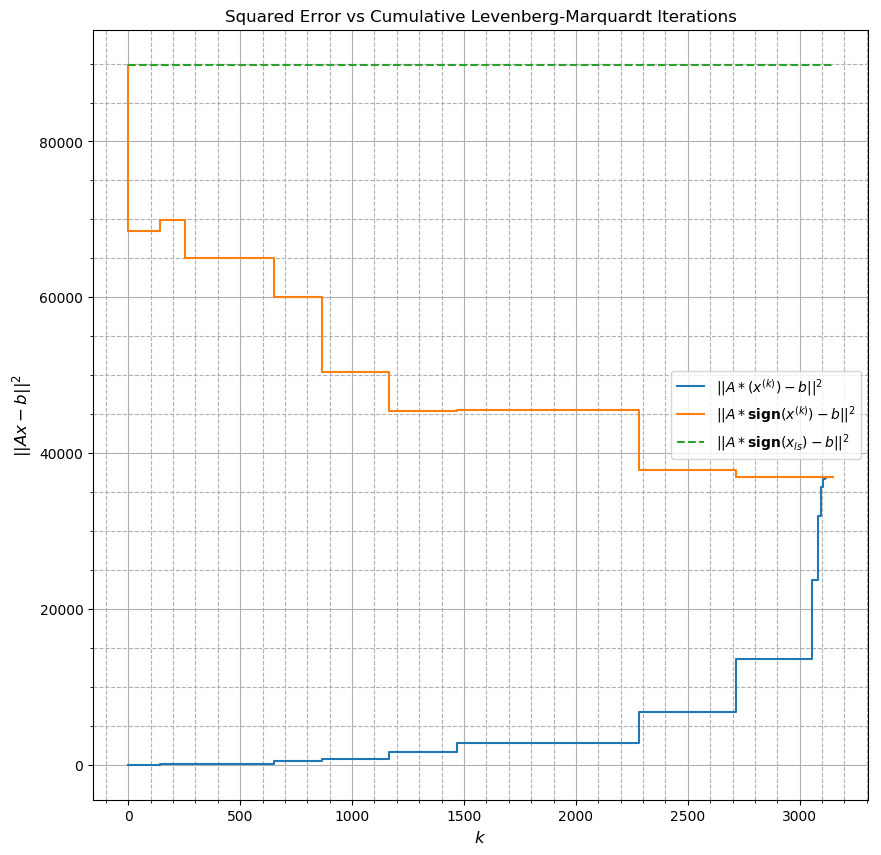

In [22]:
figure(figsize=(10,10));

step(cume_iters_al, ftraj_exact_al, label=L"$||A*(x^{(k)})-b||^2$");
step(cume_iters_al, ftraj_bool_al, label=L"$||A*\mathbf{sign}(x^{(k)})-b||^2$");
plot(cume_iters_al, f_bool_ls * ones(length(cume_iters_al)), linestyle="--", label=L"$||A*\mathbf{sign}(x_{ls})-b||^2$");

legend();
title("Squared Error vs Cumulative Levenberg-Marquardt Iterations");
xlabel(L"$k$", fontsize=12);
ylabel(L"$||Ax -b||^2$", fontsize=12);


grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on();